****
# Customer Segmentation using Unsupervised Learning
****
<p style="text-align: right"><i>Jesus Perez Colino<br>First version: Feb. 2020<br></i></p>

## About this notebook: 
****
Notebook prepared by **Jesus Perez Colino** Version 0.1, First Released: 15/02/2020, Alpha

- This work is licensed under a [Creative Commons Attribution-ShareAlike 3.0 Unported License](http://creativecommons.org/licenses/by-sa/3.0/deed.en_US). This work is offered for free, with the hope that it will be useful.


- **Summary**: 

>This notebook aim to analyse  the publicly available [dataset of Online Retail provided by the UCI](http://archive.ics.uci.edu/ml/datasets/Online+Retail+II) the give a simple example of how to do customer segmentation using unsupervised learning.

- **Index**: 
    1. Building pipelines for data preprocessing
    2. Building pipelines to get moments and frequency over total per client_id in weekly scale
    3. Optimal number of clusters
    4. Churning probabilistic models

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans, SpectralClustering, AgglomerativeClustering, AffinityPropagation, Birch
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

import logging
logging.basicConfig(format="%(asctime)s - [%(levelname)5s] - %(message)s", datefmt='%H:%M:%S')
root_logger = logging.getLogger()
root_logger.setLevel(logging.INFO)

In [2]:
%load_ext watermark
print(' Reproducibility conditions for this notebook '.center(85,'-'))
%watermark -n -v -m -p numpy,scipy,matplotlib,pandas,sklearn
print('-'*85)

-------------------- Reproducibility conditions for this notebook -------------------
Sun Feb 16 2020 

CPython 3.6.10
IPython 7.12.0

numpy 1.18.1
scipy 1.4.1
matplotlib 3.1.3
pandas 1.0.1
sklearn 0.22.1

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
CPU cores  : 8
interpreter: 64bit
-------------------------------------------------------------------------------------


# 1. Building pipelines for data preprocessing

In [3]:
url_link = "http://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"
data_df = pd.read_excel(url_link)

In [4]:
# Logger decorator

def timelog(f):
    def wrapper(dataf, *args, **kargs):
        tic = dt.datetime.now()
        result = f(dataf, *args, **kargs)
        toc = dt.datetime.now()
        if isinstance(result, pd.DataFrame) | isinstance(result, pd.Series) : status = 'OK'
        else: status = 'Check the function output'
        logging.info(f"{f.__name__} took {toc - tic} with result size = {result.shape} --> {status}")
        return result
    return wrapper  

In [5]:
@timelog
def start_pipeline(raw_df):
    df_clean = raw_df.copy()
    return df_clean

@timelog
def clean_na(raw_df):
    df_clean = raw_df.dropna(axis=0, 
                             subset=['Customer ID'])
    return df_clean

@timelog
def clean_duplicates(raw_df):
    indx = raw_df[raw_df.duplicated(keep='first')].index
    df_clean = raw_df.drop(index=indx)
    return df_clean

@timelog
def clean_cancelled(raw_df):
    indx = raw_df.Invoice[raw_df.Invoice.str.contains('C') == True].index
    df_clean = raw_df.drop(index= indx)
    return df_clean

@timelog
def clean_zeros(raw_df):
    indx = raw_df.loc[raw_df.Price == 0].index
    df_clean = raw_df.drop(index=indx)
    return df_clean

In [6]:
data_clean_df = (data_df.pipe(start_pipeline)
                        .pipe(clean_na)
                        .pipe(clean_duplicates)
                        .pipe(clean_cancelled)
                        .pipe(clean_zeros))

11:25:03 - [ INFO] - start_pipeline took 0:00:00.034917 with result size = (525461, 8) --> OK
11:25:04 - [ INFO] - clean_na took 0:00:00.059878 with result size = (417534, 8) --> OK
11:25:04 - [ INFO] - clean_duplicates took 0:00:00.338095 with result size = (410763, 8) --> OK
11:25:04 - [ INFO] - clean_cancelled took 0:00:00.591417 with result size = (400947, 8) --> OK
11:25:05 - [ INFO] - clean_zeros took 0:00:00.057884 with result size = (400916, 8) --> OK


# 2. Building pipelines to get moments and frequency over total per client_id in weekly scale

In [7]:
@timelog
def time_customer_matrix(clean_df, frequency = 'W'):
    clean_df['Total'] = clean_df['Quantity']*clean_df['Price']
    clean_df_by_customer = (clean_df.groupby(['Customer ID','InvoiceDate']).agg({'Total' : 'sum'}))
    df = clean_df_by_customer.unstack().T
    matrix = df.reset_index("InvoiceDate").set_index("InvoiceDate").resample(frequency , convention='end').sum()
    return matrix

@timelog
def std_scaler(df):
    sc = StandardScaler()
    df_sc = pd.DataFrame(sc.fit_transform(df), columns=df.columns)
    return df_sc

@timelog
def adjusted_mean(df):
    df_mean = pd.DataFrame(df.mean()/df.std(), columns = ['adj_mean'])
    return df_mean

@timelog
def frequency(df):
    df_freq = pd.DataFrame(df.astype(bool).sum(axis=0), columns = ['frequency'])
    return df_freq


In [8]:
# Time/customer Matrix sample

customer_matrix = (data_clean_df.pipe(start_pipeline)
                                .pipe(time_customer_matrix))

customer_matrix.resample('M').sum().head(10)

11:25:05 - [ INFO] - start_pipeline took 0:00:00.027964 with result size = (400916, 8) --> OK
11:25:05 - [ INFO] - NumExpr defaulting to 8 threads.
11:25:07 - [ INFO] - time_customer_matrix took 0:00:02.310812 with result size = (54, 4312) --> OK


Customer ID,12346.0,12347.0,12348.0,12349.0,12351.0,12352.0,12353.0,12355.0,12356.0,12357.0,...,18277.0,18278.0,18279.0,18280.0,18281.0,18283.0,18284.0,18285.0,18286.0,18287.0
InvoiceDate,,,,,,,,,,,,,,,,,,,,,
2009-12-31,113.50,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,462.95,0.00
2010-01-31,90.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00
2010-02-28,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,96.90,0.0,427.0,0.00,0.00
2010-03-31,27.05,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,235.12,0.0,0.0,0.00,0.00
2010-04-30,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00
2010-05-31,0.00,0.0,0.0,1268.52,0.0,0.0,0.0,488.21,0.0,0.0,...,0.00,0.0,0.00,0.0,120.32,0.00,0.0,0.0,0.00,1071.61
2010-06-30,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00
2010-07-31,142.31,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,0.00,0.0,231.34,0.0,0.00,0.00,0.0,0.0,0.00,0.00
2010-08-31,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,...,337.14,0.0,0.00,0.0,0.00,92.00,0.0,0.0,833.48,0.00


In [9]:
adjusted_mean = (data_clean_df.pipe(start_pipeline)
                              .pipe(time_customer_matrix)
                              .pipe(adjusted_mean)
                              .pipe(std_scaler))

11:25:07 - [ INFO] - start_pipeline took 0:00:00.020944 with result size = (400916, 8) --> OK
11:25:09 - [ INFO] - time_customer_matrix took 0:00:02.430536 with result size = (54, 4312) --> OK
11:25:09 - [ INFO] - adjusted_mean took 0:00:00.002993 with result size = (4312, 1) --> OK
11:25:09 - [ INFO] - std_scaler took 0:00:00.001994 with result size = (4312, 1) --> OK


In [10]:
frequency = (data_clean_df.pipe(start_pipeline)
                          .pipe(time_customer_matrix)
                          .pipe(frequency)
                          .pipe(std_scaler))

11:25:09 - [ INFO] - start_pipeline took 0:00:00.029921 with result size = (400916, 8) --> OK
11:25:12 - [ INFO] - time_customer_matrix took 0:00:02.351745 with result size = (54, 4312) --> OK
11:25:12 - [ INFO] - frequency took 0:00:00.001995 with result size = (4312, 1) --> OK
11:25:12 - [ INFO] - std_scaler took 0:00:00.002993 with result size = (4312, 1) --> OK


In [11]:
data_stats = pd.concat([adjusted_mean, frequency], axis=1)
data_stats.describe()

,adj_mean,frequency
count,4.312000e+03,4.312000e+03
mean,5.871025e-17,5.450701e-17
std,1.000116e+00,1.000116e+00
min,-7.637899e-01,-5.982648e-01
25%,-7.637899e-01,-5.982648e-01
50%,-2.898686e-01,-3.787330e-01
75%,3.500397e-01,6.033051e-02
max,1.340172e+01,1.037832e+01


# 3. Optimal Number of Clusters by silhouette_score

In [17]:
@timelog
def optimal_number_clusters(clustering_model, data_stats, max_clusters = 10):
    score = {}
    for k in range(2, max_clusters):
        labels = eval( f"{clustering_model}(n_clusters={k}).fit_predict(data_stats.values)")
        score[k] = silhouette_score(data_stats.values, labels, metric = 'euclidean')
        clusters_w_max_score = [max(score, key=score.get)]
    return pd.DataFrame(clusters_w_max_score)

@timelog
def customer_clusters(df, num_clusters=2):
    labels = pd.DataFrame(KMeans(n_clusters=num_clusters).fit_predict(df.values))
    low_value_costumers = len(labels[labels==0].dropna().index.tolist())/len(labels.values)
    high_value_costumers = len(labels[labels==1].dropna().index.tolist())/len(labels.values)
    customer_clustering = pd.DataFrame([low_value_costumers*100, high_value_costumers*100], 
                                  index=['low_value_costumers','high_value_costumers'],
                                  columns=['percentage'])
    return customer_clustering

def plotting_clusters_kmeans(df, num_clusters = 2):
    labels = KMeans(n_clusters=num_clusters).fit_predict(df.values)
    plt.style.use('ggplot')
    fig = plt.scatter(df.values[:,0], df.values[:,1], c=labels, s=50, cmap ='brg', alpha=.2)
    return fig;

In [18]:
clustering_models = { 'KMeans': KMeans(),
                      'SpectralClustering':SpectralClustering(),
                      'AgglomerativeClustering': AgglomerativeClustering(),
                      'Birch': Birch() }

for name, model in clustering_models.items():
    print(f"Optimal Number of Cluster for {name}: {optimal_number_clusters(name, data_stats).values} \n\n")
    

11:28:52 - [ INFO] - optimal_number_clusters took 0:00:03.644279 with result size = (1, 1) --> OK


Optimal Number of Cluster for KMeans: [[2]] 




11:29:18 - [ INFO] - optimal_number_clusters took 0:00:25.906037 with result size = (1, 1) --> OK


Optimal Number of Cluster for SpectralClustering: [[2]] 




11:29:25 - [ INFO] - optimal_number_clusters took 0:00:07.466010 with result size = (1, 1) --> OK


Optimal Number of Cluster for AgglomerativeClustering: [[2]] 




11:29:29 - [ INFO] - optimal_number_clusters took 0:00:03.844707 with result size = (1, 1) --> OK


Optimal Number of Cluster for Birch: [[2]] 




In [19]:
customer_clusters(data_stats)

11:29:55 - [ INFO] - customer_clusters took 0:00:00.067817 with result size = (2, 1) --> OK


,percentage
low_value_costumers,86.479592
high_value_costumers,13.520408


As a conclusion, it is not difficult to see that all the models look to separate between two different kind of customers: 
1. **highly stable and profitable customers** (with high frequecy buys and high adj_mean total value customer) clients 
2. **sporadic or random customers** (with low frequency and /or low total and/or high volatile total amount per invoice)

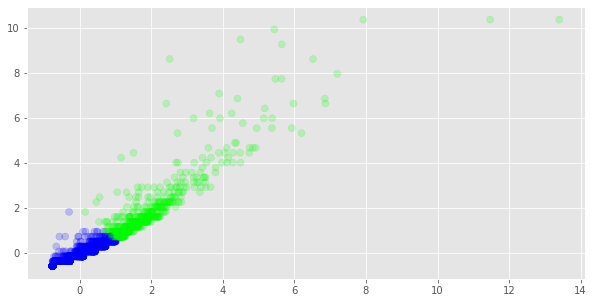

In [21]:
plotting_clusters_kmeans(data_stats, num_clusters = 2);

# 4. Churning probabilistic models

#### TODO: it has to be done ONLY over the more frequent and valueable group of customers (splitted in previous section), and there is several methodologies (all coming from Queueing theory and Markov Chains), here the easiest ones:
##### 1. Use dicrete Markov Chain: parametrize a transition matrix of states 'buy/no_buy_tomorrow // bought/no_bought_yesterday'
##### 2. Using continuous Markov Chains: parametrize exponential function for time between two buys.